In [4]:
# Brain Tumor Recognition

# Vorgehen
1. Data preprocessing
2. Convulutional NN aufbauen
3. CNN trainieren
4. Analysieren
5. Falls möglich: Dense Network anhängen

# Data Preprocessing

In [5]:
%pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Importieren der benötigten Bibliotheken
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import seaborn as sns
import random

2025-01-03 12:08:44.570532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-03 12:08:44.589849: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-03 12:08:44.595587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-03 12:08:44.611034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-03 12:08:45.622368: W tensorflow/compiler/tf2

In [7]:
# Seed setzen für Reproduzierbarkeit
seed = 42
# Für Tenserflow
tf.random.set_seed(seed)
# Für Numpy
np.random.seed(seed)
# Für Random
random.seed(seed)

In [8]:
# Laden der Daten
base_dir = os.path.join(os.getcwd(), "Daten")
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Testing")

# Parameter für die Datenverarbeitung
# Batch size
batch_size = 64
# Vereinheitlichung der Bildgrössen
img_height = 224
img_width = 224

# Training-Datensatz laden, erkennt die Labels anhand der Ordnerbeschriftungen
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),  # Bilder auf einheitliche Größe skalieren
    batch_size=batch_size,
    seed=seed
)

# Test-Datensatz laden, erkennt die Labels anhand der Ordnerbeschriftungen
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Überprüfung der geladenen Daten
print("Trainingsdatenklassen:", train_ds.class_names)
print("Testdatenklassen:", test_ds.class_names)

Found 3421 files belonging to 2 classes.


2025-01-03 12:08:48.113004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13294 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:88:00.0, compute capability: 8.6


Found 1310 files belonging to 2 classes.
Trainingsdatenklassen: ['No_Tumor', 'Tumor']
Testdatenklassen: ['No_Tumor', 'Tumor']


In [9]:
# Funktion, um die Anzahl der Bilder pro Klasse zu zählen
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Nur Ordner (Klassen) berücksichtigen
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
    return class_counts

# Zähle Bilder im Trainings- und Testordner
train_class_counts = count_images_per_class(train_dir)
test_class_counts = count_images_per_class(test_dir)

# Ausgabe der Ergebnisse
print("Anzahl der Bilder pro Klasse (Training):")
for class_name, count in train_class_counts.items():
    print(f"  {class_name}: {count}")

print("\nAnzahl der Bilder pro Klasse (Testing):")
for class_name, count in test_class_counts.items():
    print(f"  {class_name}: {count}")


Anzahl der Bilder pro Klasse (Training):
  Tumor: 2071
  No_Tumor: 1350

Anzahl der Bilder pro Klasse (Testing):
  Tumor: 905
  No_Tumor: 405


Die beiden Klassen Tumor und No_Tumor haben in den Test- respektive Trainingsdaten unterschiedlich viele Anzahl Bilder. Dies könnte später zu einem Bias im Modell führen, da das Modell mehr Bilder mit Tumor sieht als ohne.

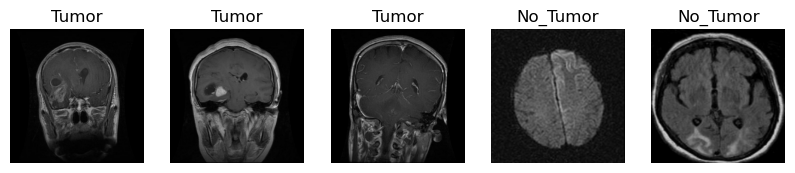

In [10]:
# Anzahl der Bilder, die angezeigt werden sollen
num_images = 5

# Hole eine kleine Stichprobe von Bildern und Labels
image_batch, label_batch = next(iter(train_ds))

# Anzeigen der Bilder und ihrer Klassen
plt.figure(figsize=(10, 10))

for i in range(num_images):
    ax = plt.subplot(1, num_images, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[label_batch[i].numpy()])
    plt.axis("off")

plt.show()


Oben ist eine zufällige Auswahl von 5 Bildern im Testdatensatz ersichtlich. Bei mehrmaligem Ausführen werden stets neue (andere) Bilder angezeigt. Dies soll helfen, besser zu verstehen, wie die MRI-Bilder aussehen und wo es Probleme geben könnte. Auffällig ist natürlich, dass die MRI-Bilder verschiedene Perspektiven haben (seitlich, von oben, von vorne etc.), was evtl. ein Problem für das Modell sein könnte.

In [11]:
# Modell erstellen
model = models.Sequential([
    # Rescaling Layer: Skaliert die Pixelwerte der Eingabebilder (von 0-255 auf 0-1)
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # Erstes Convolutional Layer: Fährt mit einer 2D-Faltung, um Merkmale aus den Bildern zu extrahieren
    layers.Conv2D(32, (5, 5), activation='relu'), # 32 Filter, Kernelgröße 5x5, ReLU-Aktivierungsfunktion
    # Max-Pooling Layer: Reduziert die Bildgröße (downsizing) und extrahiert die wichtigsten Merkmale
    layers.MaxPooling2D((2, 2)), # Pooling-Größe von 2x2, reduziert die Dimensionen
    # Dropout Layer: Verhindert Overfitting, indem während des Trainings zufällig ein Prozentsatz der Neuronen deaktiviert wird
    layers.Dropout(0.2), # 20% der Neuronen werden während des Trainings deaktiviert
    
    # Zweites Convolutional Layer mit Max-Pooling und Dropout
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Drittes Convolutional Layer mit Max-Pooling und Dropout
    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Flatten
    layers.Flatten(),
    # Erster Dense-Layer mit 256 Neuronen und ReLu als acrivation function
    layers.Dense(256, activation='relu'),
    # Zweiter Dense-Layer mit 128 Neuronen und ReLu als acrivation function
    layers.Dense(128, activation='relu'),
    # Dropout Layer
    layers.Dropout(0.2),
    # Dritter Dense Layer mit 2 Neuronen und softmax (weil Klassifizierungstask) als activation function
    layers.Dense(len(train_ds.class_names), activation='softmax')  # Anzahl der Klassen (Tumor/No_Tumor)
])

# Modell zusammenfassen
model.summary()

# EarlyStopping Callback definieren
early_stopping = EarlyStopping(monitor='val_accuracy',  # Überwachen der Val_Accuracy
                               patience=15,         # Geduld (wie viele Epochen ohne Verbesserung)
                               restore_best_weights=True)  # Bestes Modell wird zurückgegeben

# Modell kompilieren
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #Adam optimizer mit sehr tiefer learning
              loss='sparse_categorical_crossentropy', # Crossentropy als Lossfunktion
              metrics=['accuracy']) # Accuracy (Metrik) wird während dem Training überwacht

# Modell trainieren mit EarlyStopping
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    callbacks=[early_stopping],  # Callbacks hinzufügen
)

/opt/conda/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 49, 49, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,166,402 (73.11 MB)

 Trainable params: 19,166,402 (73.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1735906154.042871  141423 service.cc:146] XLA service 0x7fe45c002070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735906154.042920  141423 service.cc:154]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
2025-01-03 12:09:14.118109: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-03 12:09:14.311110: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-01-03 12:09:14.641595: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
20

53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7126 - loss: 0.5394

2025-01-03 12:09:53.021236: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2239', 8 bytes spill stores, 8 bytes spill loads

2025-01-03 12:09:53.336352: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2239', 24 bytes spill stores, 24 bytes spill loads

2025-01-03 12:10:02.181348: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,32,110,110]{3,2,1,0}, f32[29,64,106,106]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_s

54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 716ms/step - accuracy: 0.7165 - loss: 0.5348 - val_accuracy: 0.7351 - val_loss: 0.6302
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.9298 - loss: 0.2024 - val_accuracy: 0.8351 - val_loss: 0.3613
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.9471 - loss: 0.1662 - val_accuracy: 0.8603 - val_loss: 0.3081
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.9608 - loss: 0.1283 - val_accuracy: 0.8840 - val_loss: 0.2634
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9774 - loss: 0.0880 - val_accuracy: 0.9168 - val_loss: 0.2270
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9711 - loss: 0.0813 - val_accuracy: 0.8939 - val_loss: 0.2560
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9741 - loss: 0.0799 - val_accuracy: 0.9130 - val_loss: 0.2229
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9847 - loss: 0.0454 - val_accuracy: 0.931

Das Modell lernt rund 19 Millionen Parameter, wobei logischerweise der Grossteil der Parameter beim ersten Dense-Layer anfällt.

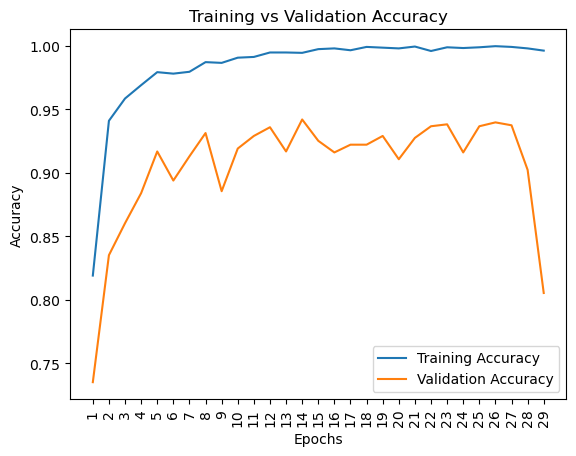

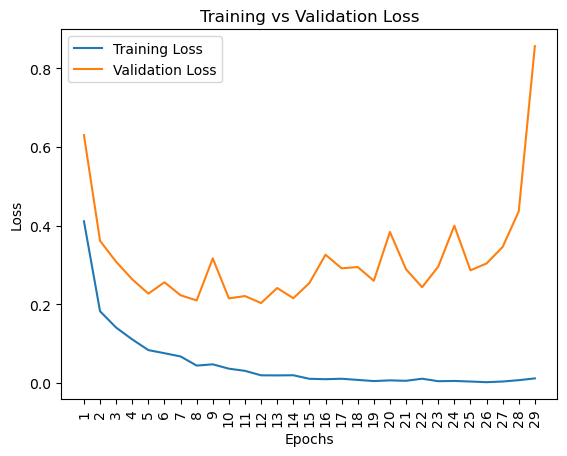

In [12]:
# Training und Validierung Accuracy plotten
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks(range(len(history.history['accuracy'])), range(1, len(history.history['accuracy']) + 1), rotation=90)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training und Validierung Loss plotten
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.xticks(range(len(history.history['accuracy'])), range(1, len(history.history['accuracy']) + 1), rotation=90)
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
# Zeige die Epoche mit der besten Validierungsgenauigkeit
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
print(f"Beste Epoche: {best_epoch + 1} (Basierend auf der höchsten Validierungsgenauigkeit)")

Beste Epoche: 14 (Basierend auf der höchsten Validierungsgenauigkeit)


Wie in den oberen beiden Grafiken zu sehen ist, verhält sich die accuracy auf den Testdaten etwas sprunghaft, was auf Overfitting deutet. Um dies entgegenzuwirken, könnte der Batch-Size erhöht werden, was jedoch das Training verlangsamen würde. Ein weiterer Grund für das sprunghafte Verhalten könnte das ungleichgewicht zwischen den Bildern sein, da viel mehr Bilder mit Tumor trainiert werden als ohne. Die höchste Accuracy auf den Testdaten erzielte das Modell in der Epoche 14, weswegen das Training in Epoche 29 mit dem Early-Stopping angehalten wurde.

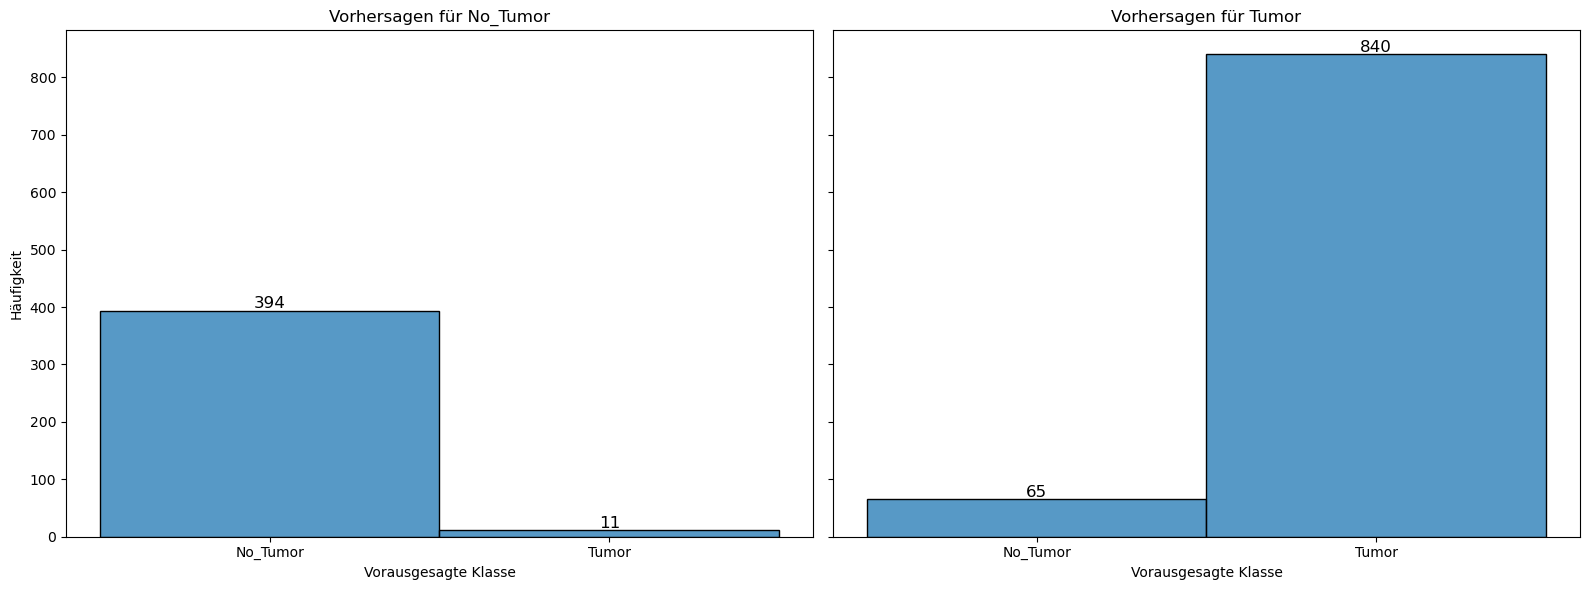

In [22]:
# Visualisierung der Häufigkeit der Vorhersagen für jedes wahre Label
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 Reihe, 2 Spalten, y-Achse wird geteilt
for i in range(len(train_ds.class_names)):  # Wir haben 2 Klassen: 'Tumor' und 'No_Tumor'
    ax = axes[i]
    sns.histplot(results_df[results_df['True Label'] == i]['Predicted Label'], bins=np.arange(3) - 0.5, kde=False, ax=ax)
    ax.set_title(f'Vorhersagen für {train_ds.class_names[i]}')
    ax.set_xlabel('Vorausgesagte Klasse')
    ax.set_ylabel('Häufigkeit')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(train_ds.class_names)

    # Zahlen über den Balken hinzufügen
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', 
                    xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


Wie bereits erwähnt hat das Modell relativ gute Ergebnisse in der Prediction erzielt. Bei der Klasse No_Tumor werden lediglich 11 von 405 Bilder falsch klassifiziert. Bei der Klasse Tumor wurden 65 von 905 Bilder falsch Klassifiziert. Die untenstehende Confusion-Matrix bestätigt, dass Bilder ohne Tumor besser vom Modell erkannt werden als Bilder mit Tumor. Dies könnte daran liegen, dass das Modell auch fast doppelt so viele Bilder mit Tumor gesehen hat als ohne. Zwar werden "nur" 7% der Bilder mit Tumor falsch vorhergesagt, jedoch ist dieser Fall besonders kritisch. Um das Modell in der Medizin anwenden zu können müsste das Modell perfekt (oder zumindest nahezu perfekt) sein bei Bildern mit Tumor.

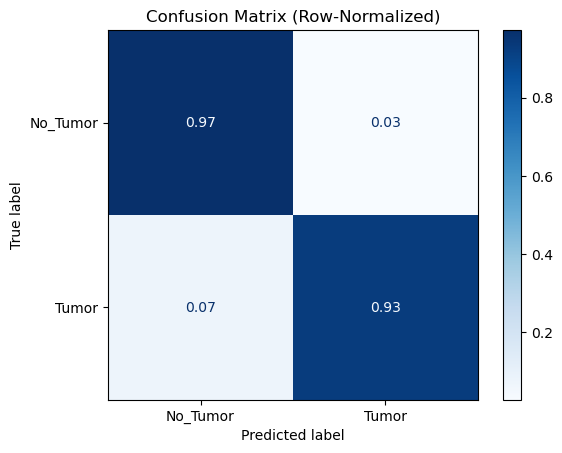

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Wahre Labels und vorhergesagte Labels aus results_df extrahieren
true_labels = results_df['True Label']
predicted_labels = results_df['Predicted Label']

# Confusion Matrix berechnen
cm = confusion_matrix(true_labels, predicted_labels)

# Skalierung der Farbskala pro Zeile
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Confusion Matrix visualisieren
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=train_ds.class_names)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')  # Werte in der Matrix mit 2 Dezimalstellen anzeigen
plt.title('Confusion Matrix (Row-Normalized)')
plt.show()

Unten ist die Modellarchitektur abgebildet.

In [16]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


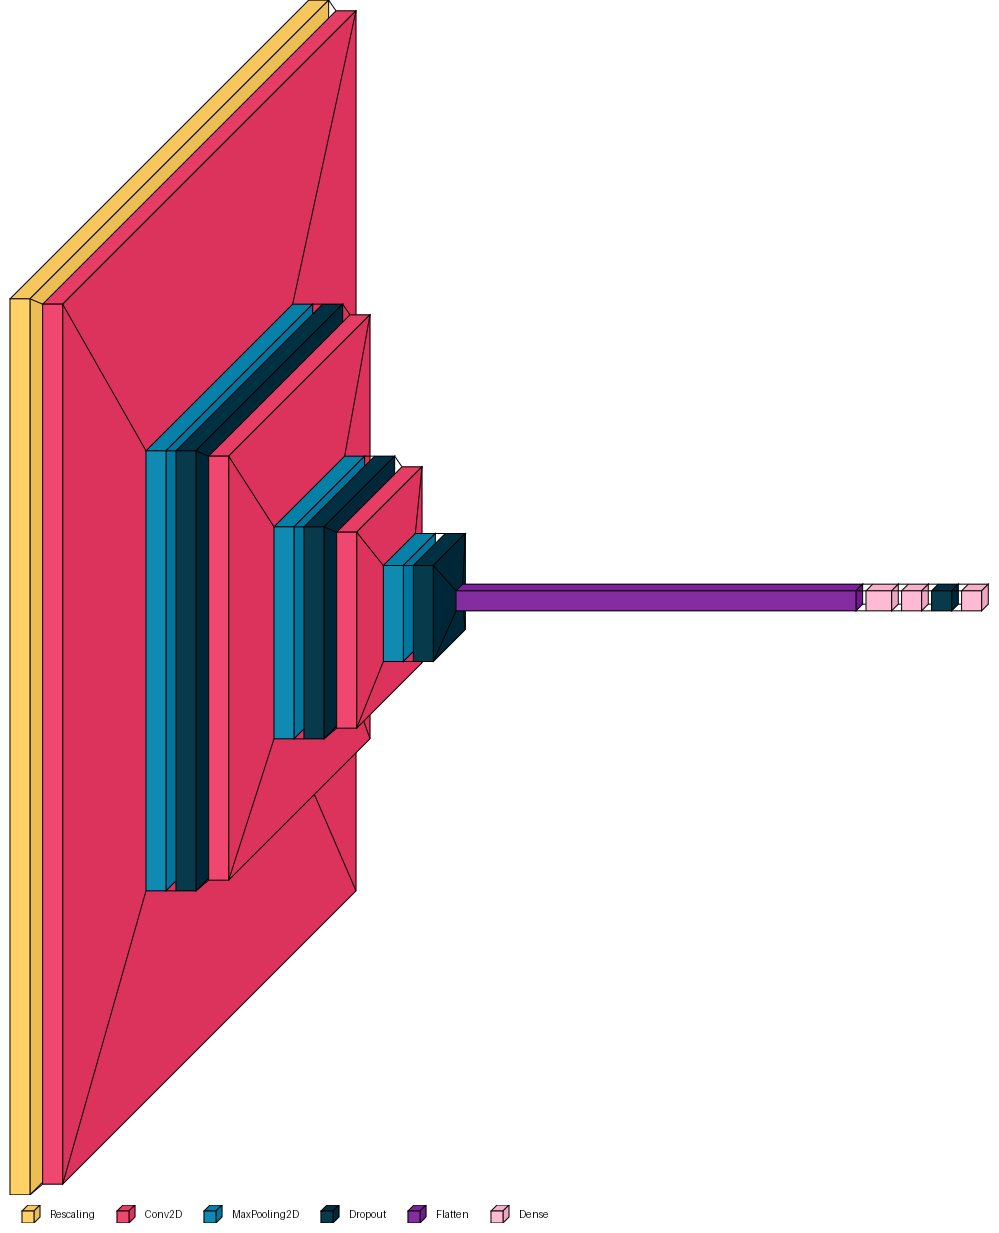

In [17]:
import visualkeras
from tensorflow.keras.models import load_model

from IPython.display import Image
# Visualisierung des Modells als PNG speichern
visualkeras.layered_view(model, legend=True).save('model_visualization.png')

# Bild anzeigen
Image('model_visualization.png')